# Visualize Test Time Augmentation with Defined Transformations

## Imports

In [73]:
# Importing essential libraries
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import torch

# Importing image processing libraries
from PIL import Image
import torchvision.transforms as T
from torchvision import models


# Add the parent directory of the current script to the system path.
sys.path.insert(0, os.pardir)

# ttach lib
import ttach as tta

## Define Model

In [74]:
def infer(input_image_tensor):
        
    # Load the pre-trained model
    model = models.segmentation.fcn_resnet101(pretrained=True).eval()

    # If a GPU is available, move the input to GPU memory
    if torch.cuda.is_available():
        input_image_tensor = input_image_tensor.to('cuda')
        model.to('cuda')

    # Model inference
    with torch.no_grad():
        output = model(input_image_tensor)['out'][0]

    # Create a binary mask by taking the argmax of the output
    mask = output.argmax(0).unsqueeze(0).unsqueeze(0) == 8 # Class number for cat class

    return mask

# Model Specific Pre Processing
model_preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

## Visualize TTA

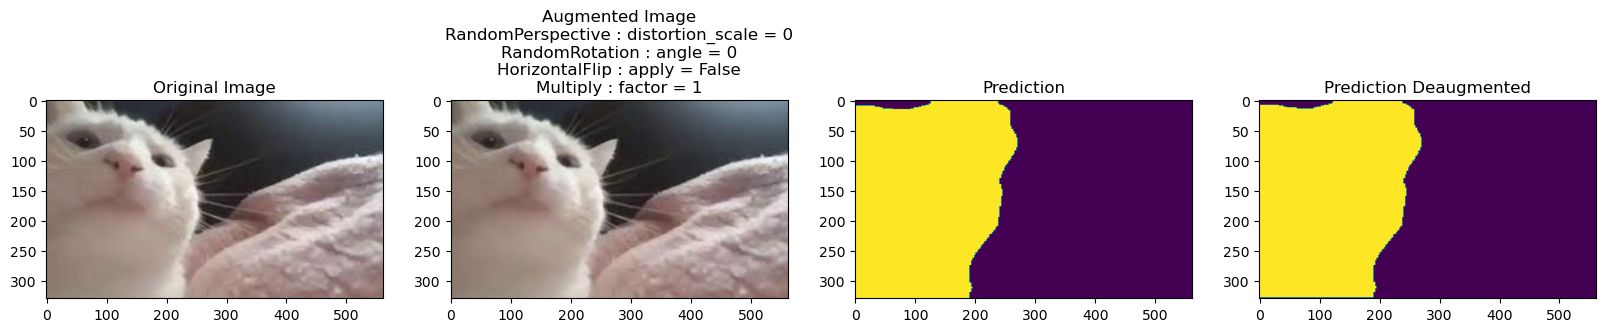

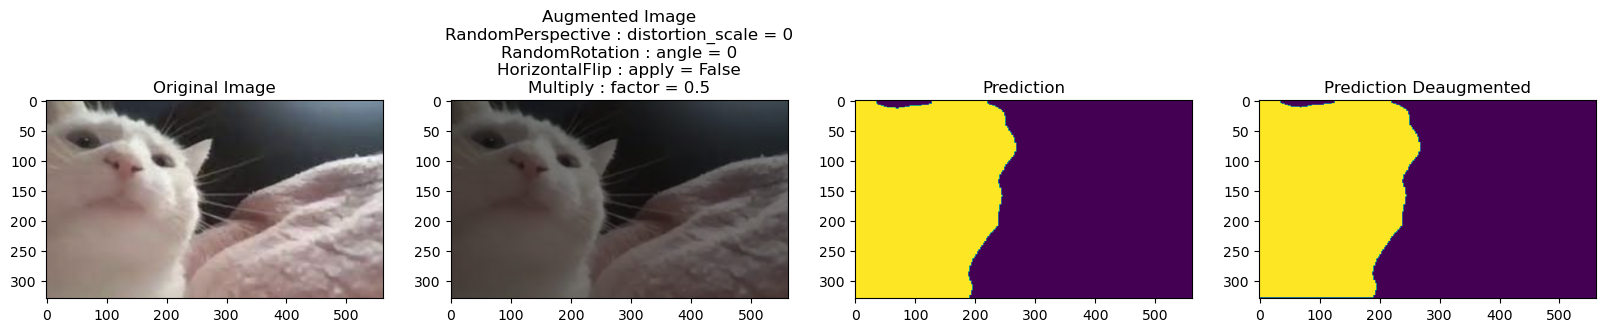

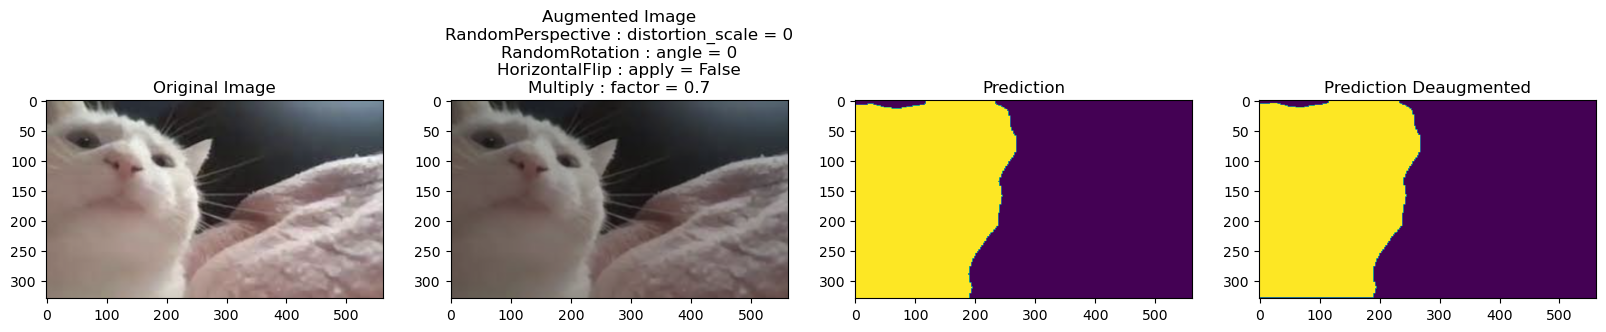

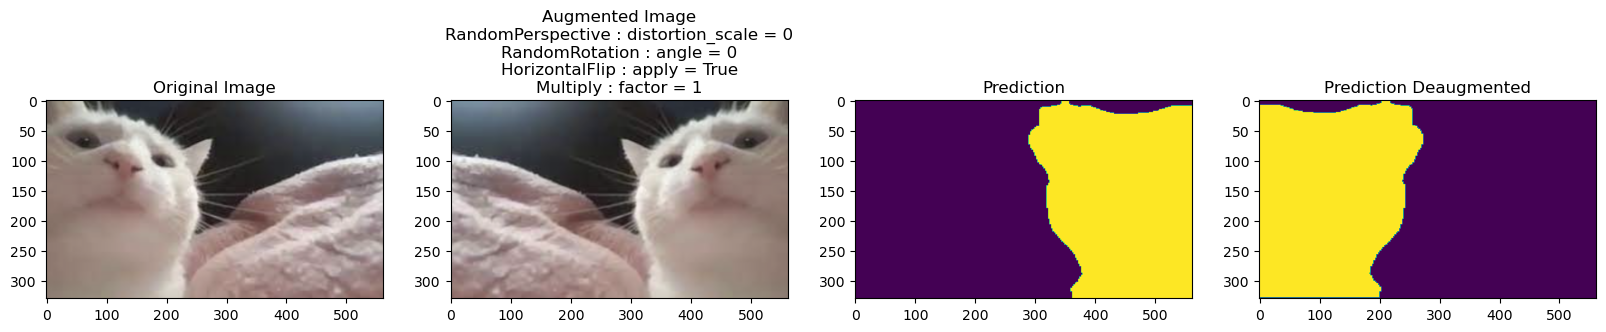

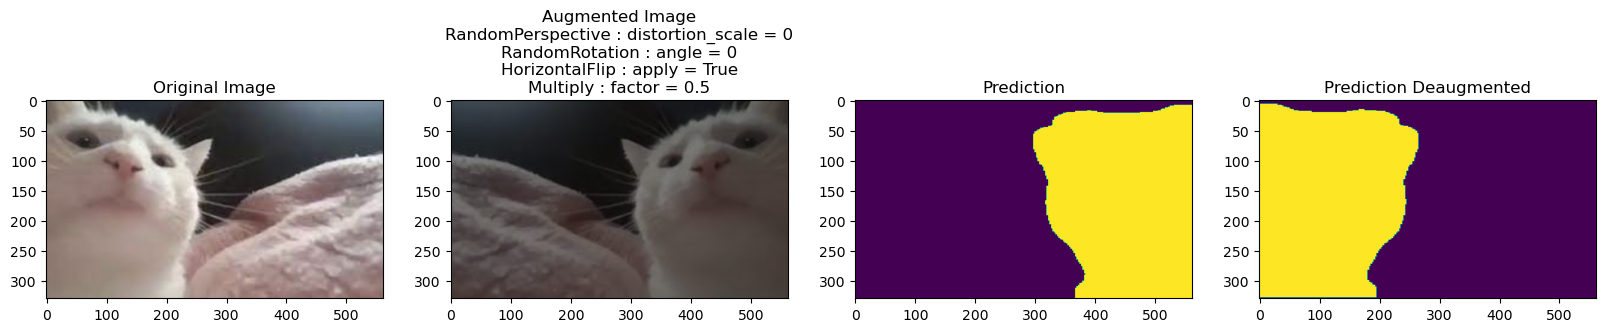

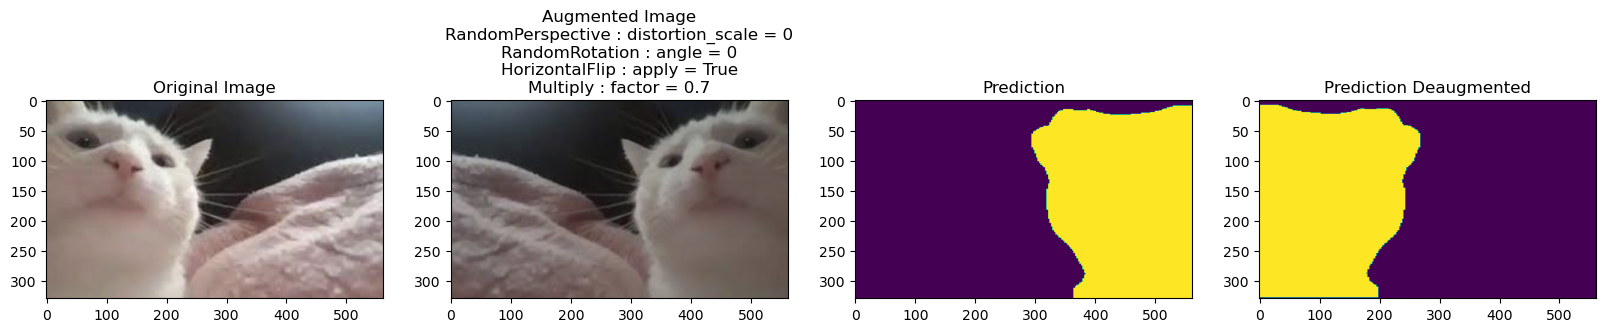

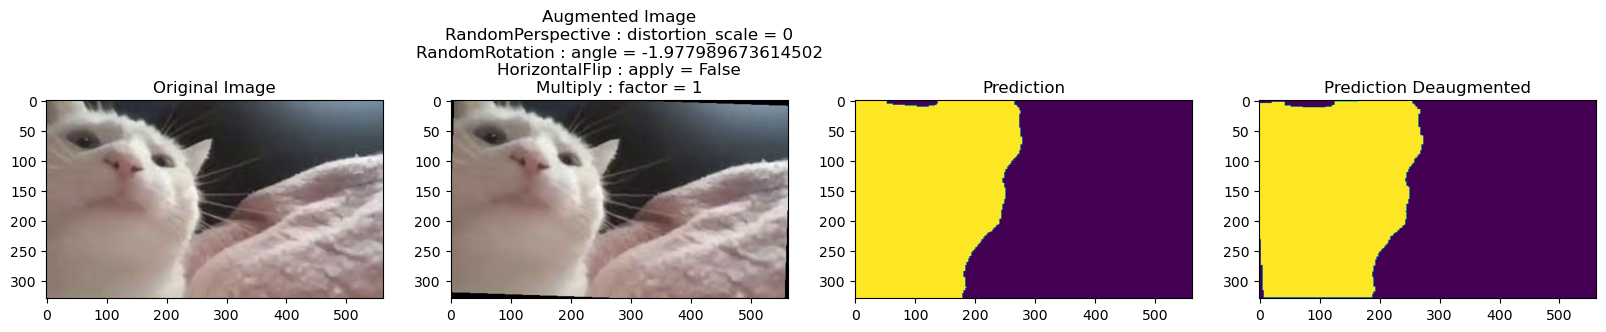

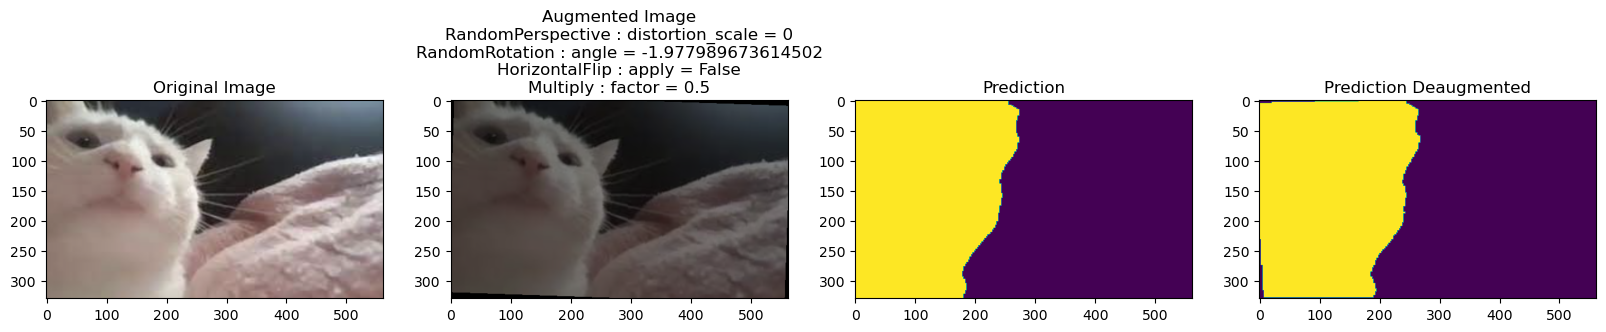

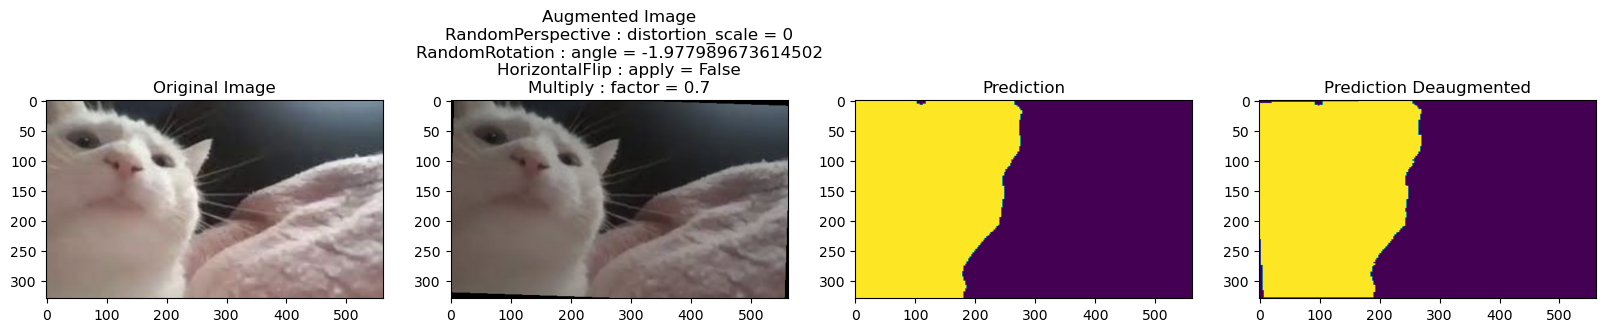

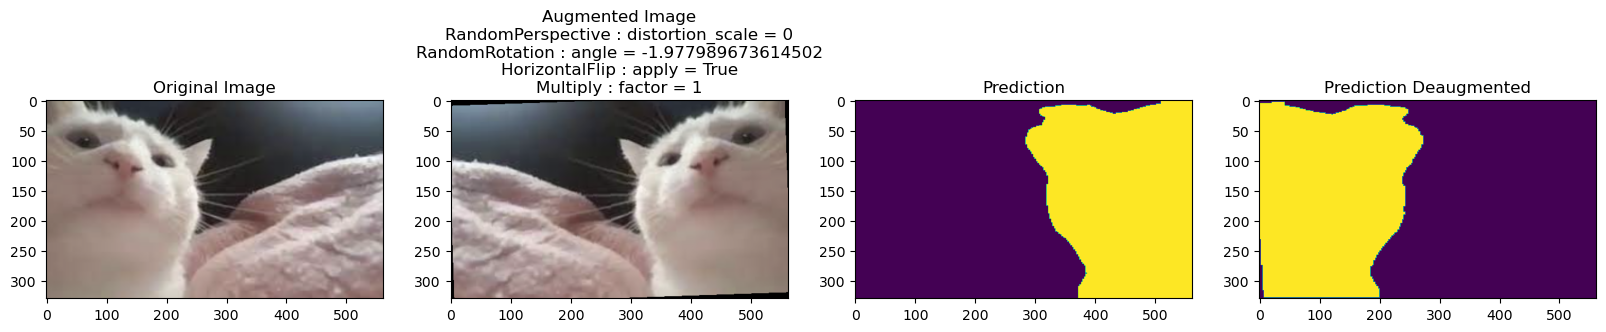

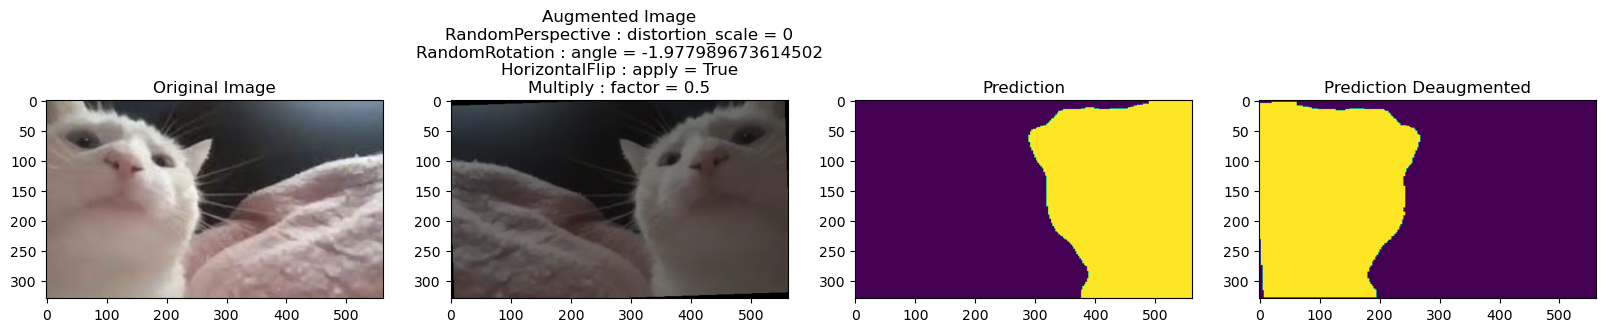

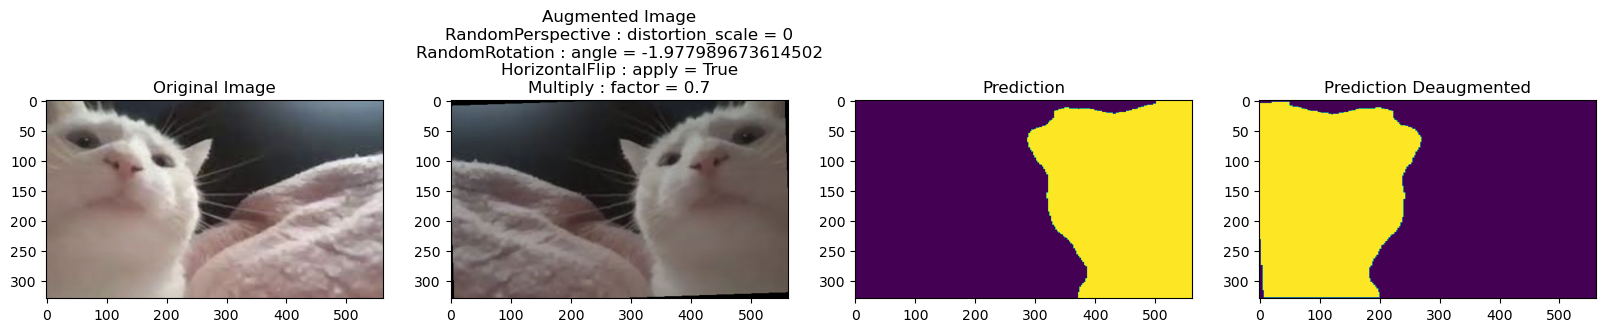

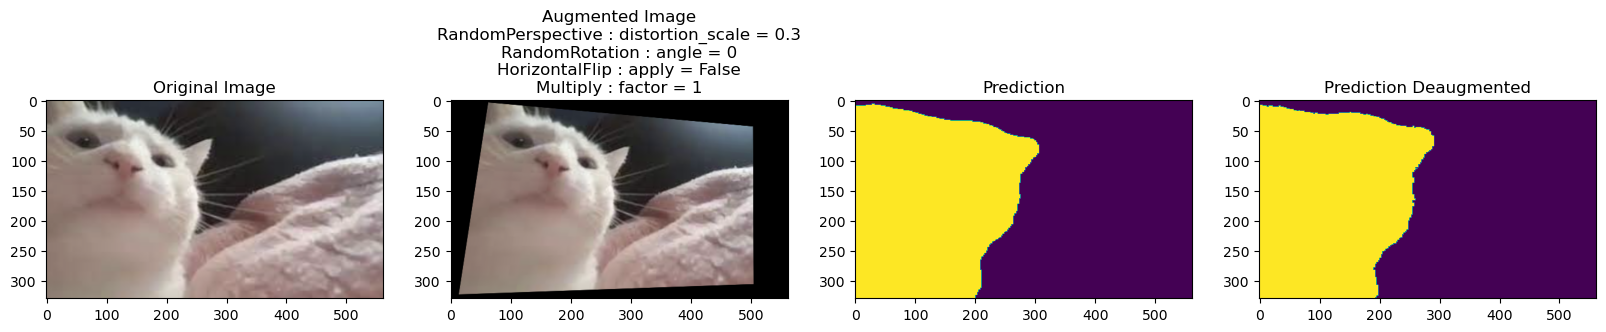

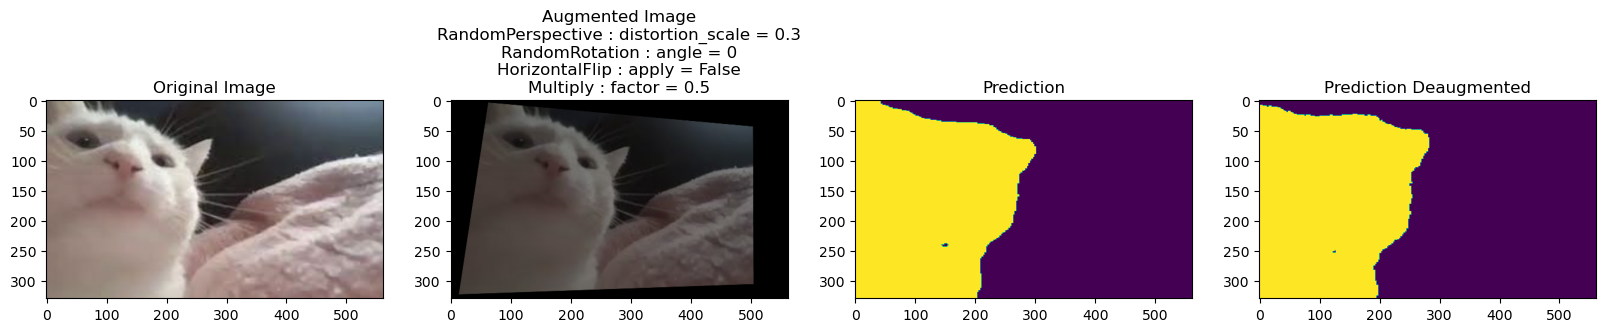

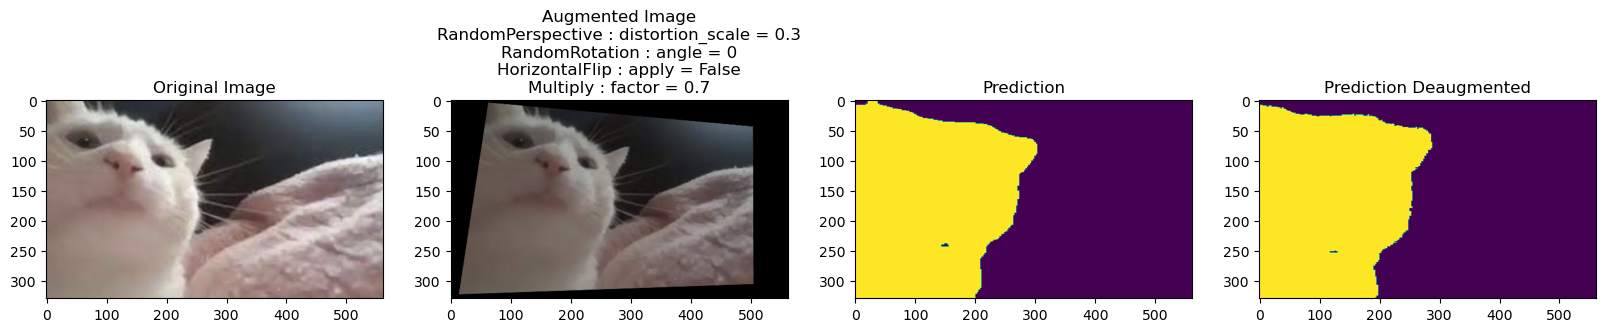

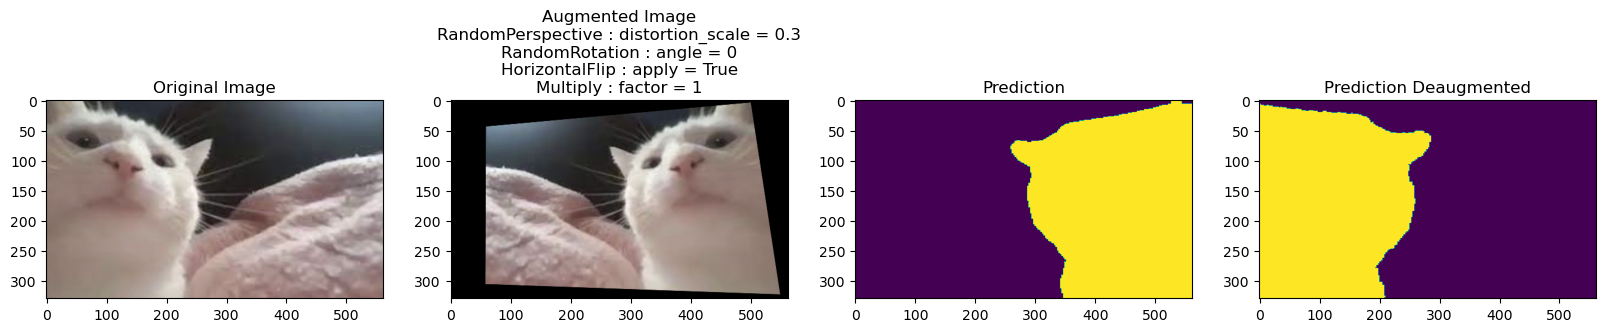

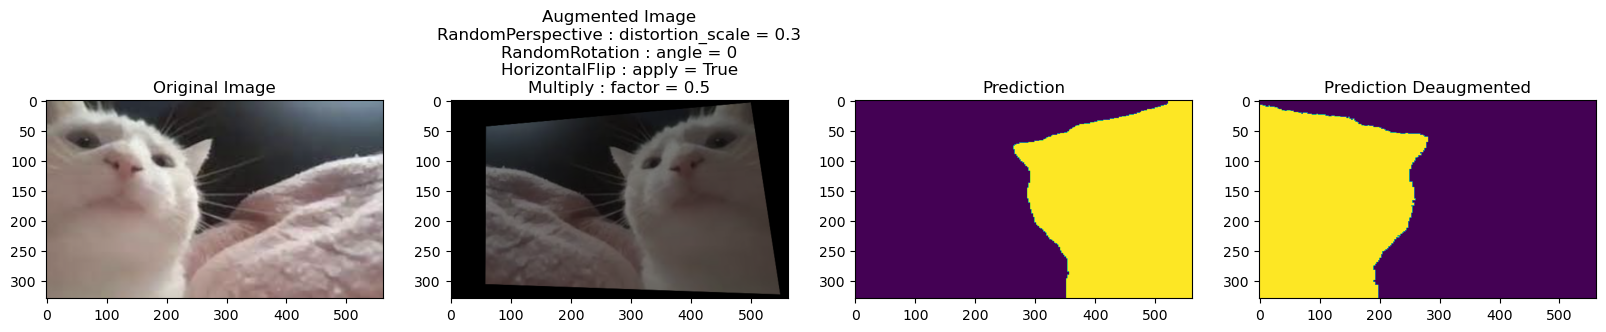

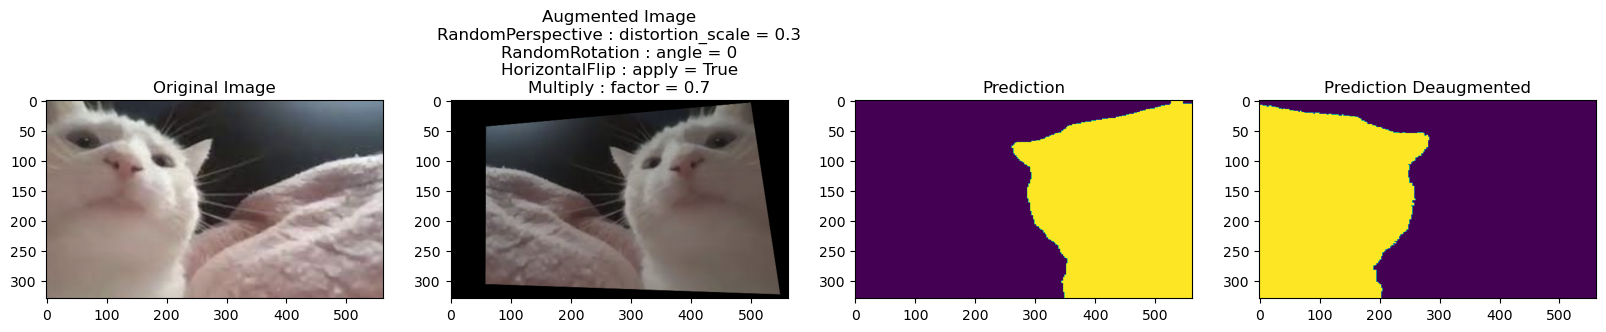

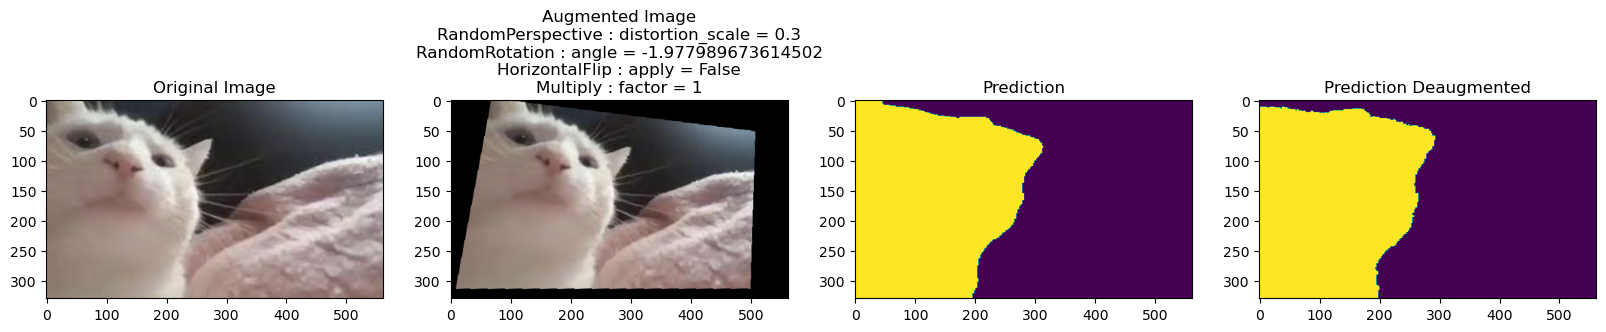

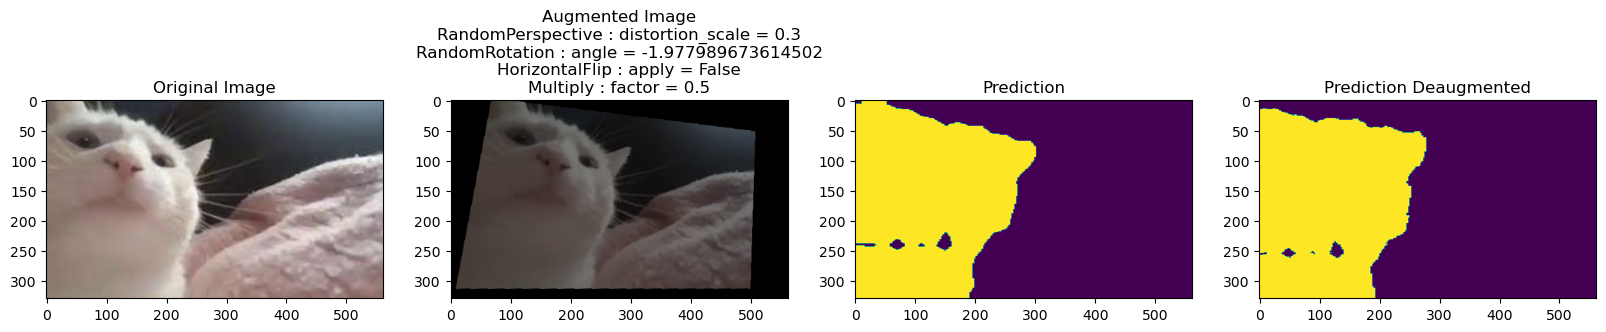

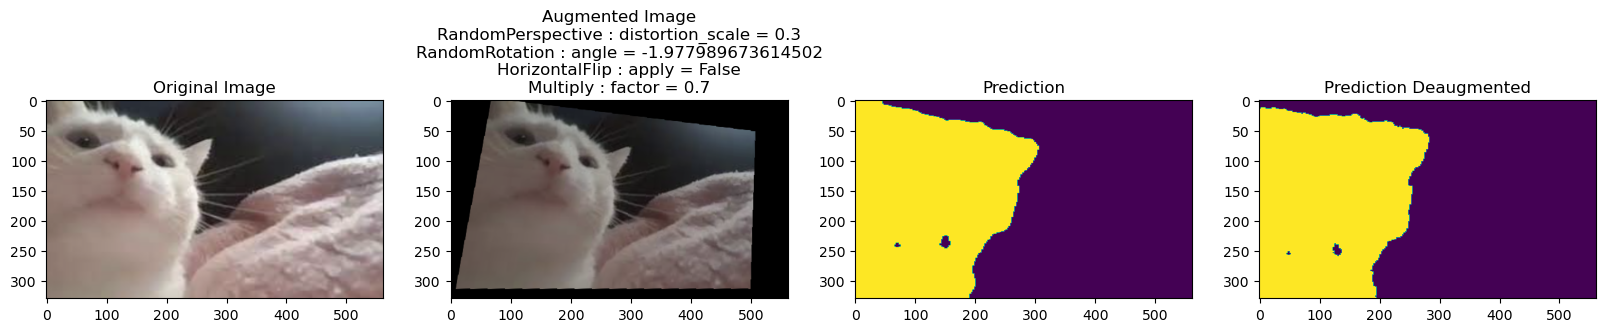

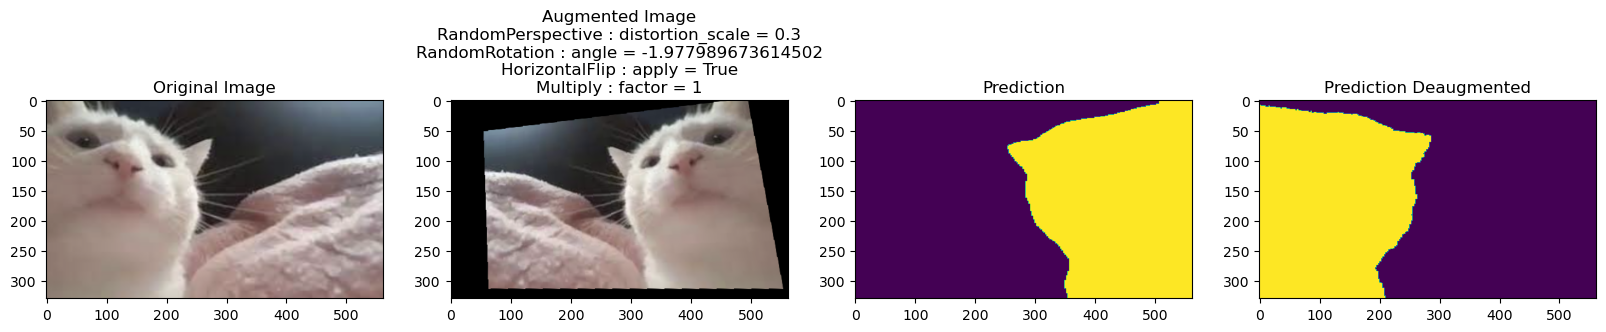

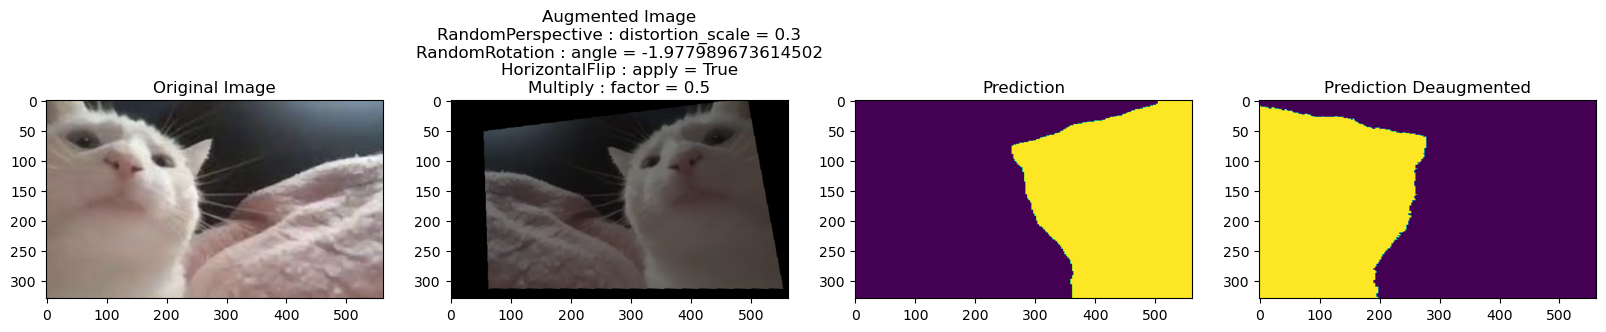

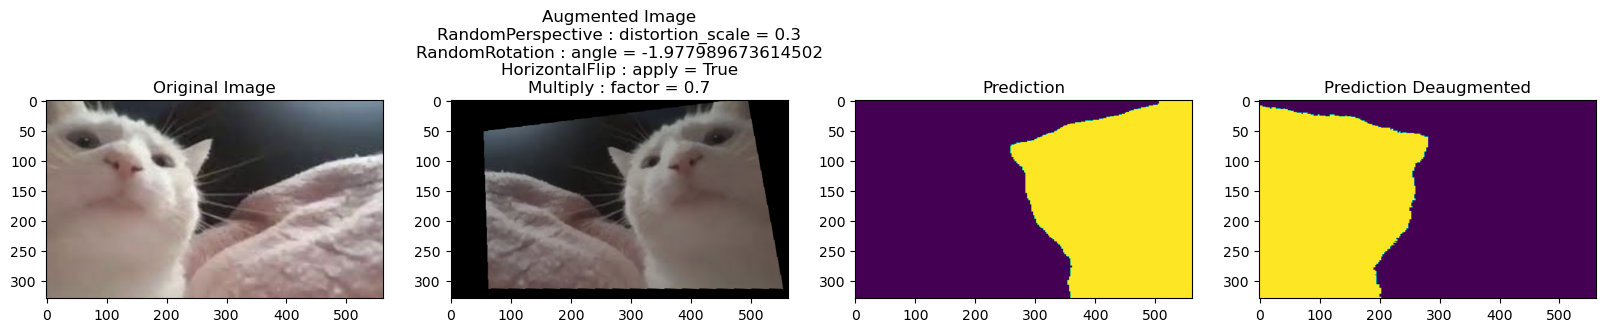

In [71]:
# Define a transformation to convert PIL images to tensors
to_tensor = T.Compose([T.ToTensor()])

# Open the image file with PIL, then apply the transformation
image = Image.open(os.path.join("assets", "vibin_cat.png"))
image = image.convert('RGB')

# Transform the image to a tensor and add an extra dimension to make it a 4D tensor (B, C, H, W)
image = to_tensor(image).unsqueeze(dim=0)

# Initialize the ttach transformations
transforms = tta.base.Compose([
    tta.transforms.RandomPerspective(distortion_scale=0.3),
    tta.transforms.RandomRotation(degree=10),
    tta.transforms.HorizontalFlip(),
    tta.Multiply(factors=[0.5, 0.7])
])
    
# Retrieve the names and parameters of the transformations for display purposes
transforms_names_and_params = tta.utils.get_transform_names_and_params(transforms)

masks = []

for i, transformer in enumerate(transforms):
    
    # augment image
    augmented_image = transformer.augment_image(image)
    
    # Pre Process Image    
    input_image = model_preprocess(augmented_image)
    
    # pass to model
    mask_output = infer(input_image)
    
    # deaugment mask prediction
    deaugmented_mask = transformer.deaugment_mask(mask_output)

    # plot original and augmented images
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))

    # Preparing the original image for display
    # 'numpy()' converts the image from a tensor to a numpy array
    # 'squeeze()' removes singleton dimensions
    # 'transpose((1, 2, 0))' rearranges dimensions from (C, H, W) to (H, W, C) which is the standard format for display
    image_display = image.numpy().squeeze().transpose((1, 2, 0))
    image_display = np.clip(image_display, 0, 1)

    aug_image_display = augmented_image.numpy().squeeze().transpose((1, 2, 0))
    aug_image_display = np.clip(aug_image_display, 0, 1)
    
    # Add an extra dimension to represent the channels
    mask_display = mask_output.float()  # the interpolation function expects float data type
    mask_display = torch.nn.functional.interpolate(mask_display, size=image.size()[-2:], mode='nearest')
    # Squeeze the output to remove the channel dimension and convert it to a binary mask
    mask_display = (mask_display.squeeze(0).squeeze(0)).byte().cpu()
    
    
    deaugmented_mask_display = deaugmented_mask.float()  # the interpolation function expects float data type
    deaugmented_mask_display = torch.nn.functional.interpolate(deaugmented_mask_display, size=image.size()[-2:], mode='nearest')
    # Squeeze the output to remove the channel dimension and convert it to a binary mask
    deaugmented_mask_display = (deaugmented_mask_display.squeeze(0).squeeze(0)).byte().cpu()
    
    
    ax[0].imshow(image_display)
    ax[0].title.set_text('Original Image')

    ax[1].imshow(aug_image_display)
    ax[1].title.set_text(f'Augmented Image\n{transforms_names_and_params[i]}')  # Add augmentation details to the title

    ax[2].imshow(mask_display)
    ax[2].title.set_text(f'Prediction')
    
    ax[3].imshow(deaugmented_mask_display)
    ax[3].title.set_text(f'Prediction Deaugmented')
    
    # save results
    masks.append(deaugmented_mask_display)
    
    plt.show()


## Compare TTA with Normal Prediction

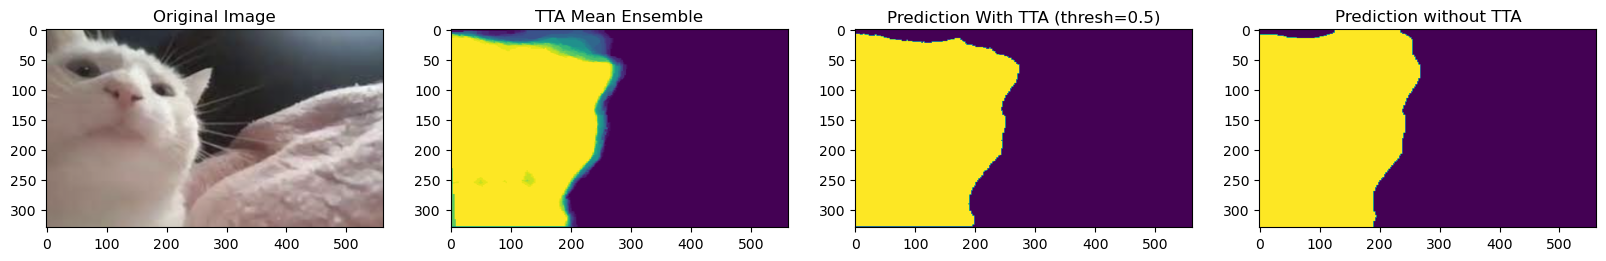

In [76]:
# Stack the arrays along a new axis
stacked_masks = np.stack(masks, axis=0)

# Calculate the mean along the new axis
mean_mask = np.mean(stacked_masks, axis=0)

thresh = 0.5

fig, ax = plt.subplots(1, 4, figsize=(20, 6))


ax[0].imshow(image_display)
ax[0].title.set_text('Original Image')

ax[1].imshow(mean_mask)
ax[1].title.set_text(f'TTA Mean Ensemble')

ax[2].imshow(mean_mask > thresh)
ax[2].title.set_text(f'Prediction With TTA (thresh={thresh})')


# Pre Process Image    
input_image = model_preprocess(image)

# pass to model
mask_output = infer(input_image)
mask_display = mask_output.float()  # the interpolation function expects float data type
mask_display = torch.nn.functional.interpolate(mask_display, size=image.size()[-2:], mode='nearest')
# Squeeze the output to remove the channel dimension and convert it to a binary mask
mask_display = (mask_display.squeeze(0).squeeze(0)).byte().cpu()

ax[3].imshow(mask_display)
ax[3].title.set_text(f'Prediction without TTA')